# Dogs and Cats

Following three lines ensure that edits to libraries are reloaded automatically, and any charts or images displayed are shown.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import necessary packages. Working with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that makes building neural networks quicker.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
# Set batch size for SGD
bs = 64

## Data

Using the  [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. According to the paper,  best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. But they didn't have deep learning! Let's see how we do vs the state of the art 7 years ago, should give persepective into how quickly the field moves.

Use the `untar_data` function which passes in an URL  argument and will download & extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing when approaching a problem is to take a look at the data (according to many machine learning books). One _always_ need to understand very well what the problem is and what the data looks like before one can figure out how to solve it. Taking a look at the data means understanding how this pet data structured, what the labels are and some sample images.

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_155.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_183.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_9.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_29.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_157.jpg')]

In [0]:
np.random.seed(2)
# For reproducibility
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

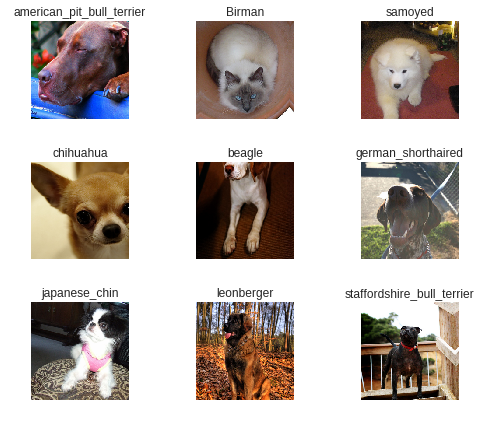

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [12]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Resnet34

I will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. A.k.a will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

 Train for 4 epochs (4 cycles through _all_ data).

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 61217709.55it/s]


In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.417159,0.303899,0.086604,01:55
1,0.549756,0.216117,0.074425,01:53
2,0.343031,0.185093,0.064953,01:56
3,0.266767,0.171088,0.058187,01:56


In [0]:
learn.save('stage-1')

## Results

Already one could see that we are outperforming the base model from the above paper, however, all this result is on the test set and could therefore be because of overfitting (though very unlikely as this is neither a very large dataset or network).

Let's first see which were the categories that the model most confused with one another. Hopefully, what the model predicts is are resonable. A confusion matrix would be a good idea.

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

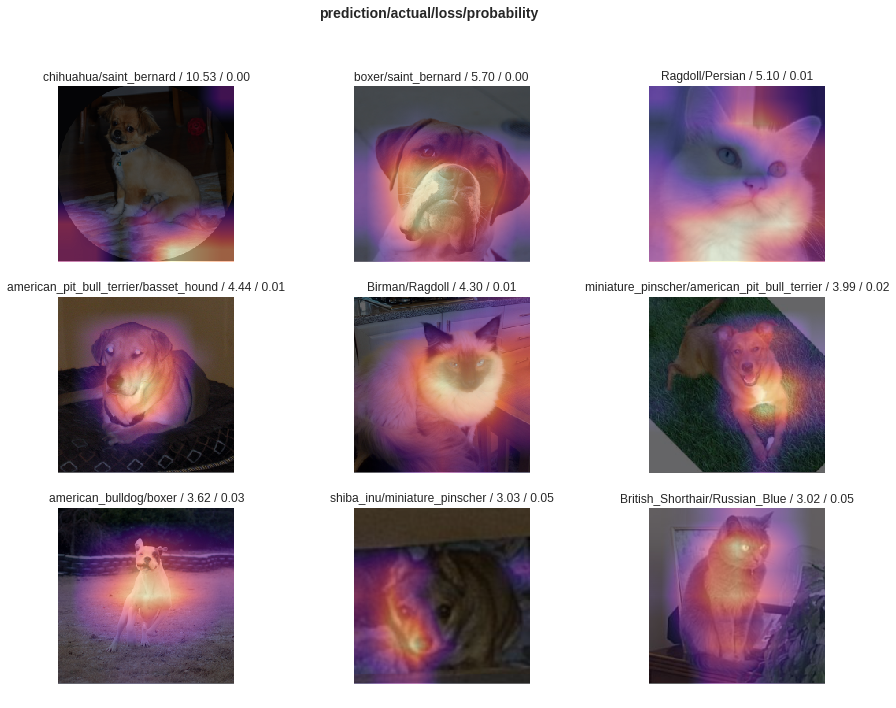

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

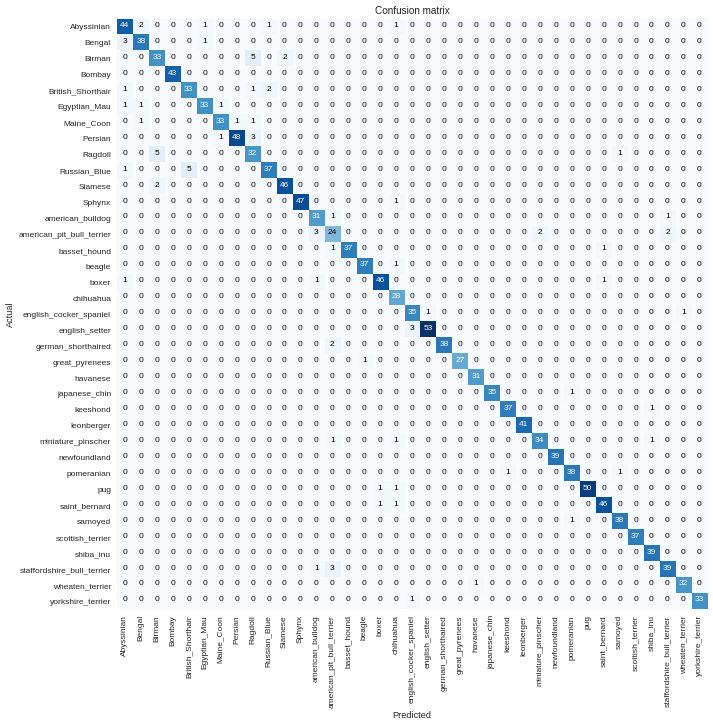

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('Birman', 'Ragdoll', 5),
 ('Ragdoll', 'Birman', 5),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('Bengal', 'Abyssinian', 3),
 ('Persian', 'Ragdoll', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Abyssinian', 'Bengal', 2),
 ('Birman', 'Siamese', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Siamese', 'Birman', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 2),
 ('german_shorthaired', 'american_pit_bull_terrier', 2)]

## Fine-tuning, and learning rates

The model is working as expected so I will *unfreeze* it and train some more.

In [0]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.519948,0.285829,0.089310,02:02


In [0]:
learn.load('stage-1');

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


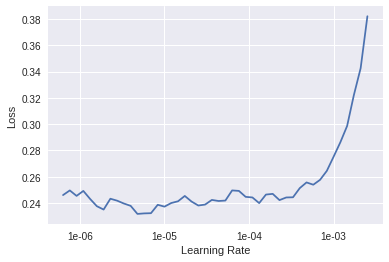

In [26]:
learn.recorder.plot()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.238745,0.163973,0.054804,02:01
1,0.213707,0.158368,0.052097,02:02


That's a pretty accurate model!

## Resnet50 (deeper)

It is clear that deep learning, specifically CNNs have done wonders to improve image recognition performance. This begs the question of whether using an even larger neural network will make a better model, so instead of using resnet34 as our backbone I will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Hopefully I will ge a higher accuracy here. Reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [29]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 55579041.18it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


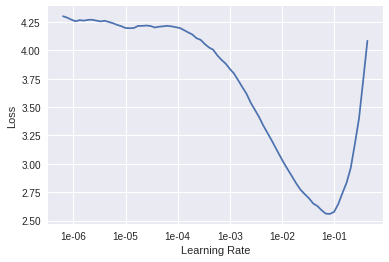

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.732775,0.283709,0.080514,03:31
1,0.414290,0.231420,0.075101,03:25
2,0.340199,0.222633,0.073072,03:26
3,0.276083,0.221516,0.066306,03:26
4,0.190695,0.226254,0.071042,03:27
5,0.156011,0.186713,0.054804,03:28
6,0.113423,0.179396,0.053451,03:27
7,0.088636,0.177707,0.050744,03:27


In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps. If it doesn't, one can always go back to a previous model.

In [50]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-3,1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.497512,0.032506,0.999019,00:25
1,0.114533,0.111427,0.993131,00:24
2,0.028607,0.000013,1.000000,00:24


In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [57]:
interp.most_confused(min_val=2)

[]